In [1]:
# src/features/temporal_autoencoder_features.py
"""
Temporal autoencoder features adapted from SHM damage localization
for structural break detection in time series
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import signal, stats
from typing import Dict, Union, Tuple, List
import warnings

from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
from src.data.dataLoader import StructuralBreakDataLoader

In [34]:
data_handler = StructuralBreakDataLoader()
data_handler.load_data(use_crunch=False)
train_dict, test_dict = data_handler.create_train_val_split(val_ratio=0.2, data_ratio=0.02)

INFO:src.data.dataLoader:Data loaded successfully from local files


In [14]:
class TemporalAutoencoder(nn.Module):
    """
    Autoencoder for temporal anomaly detection in time series
    Adapted from SHM damage localization approach
    """

    def __init__(self, input_dim: int, bottleneck_dim: int, hidden_dims: List[int] = None):
        super(TemporalAutoencoder, self).__init__()

        if hidden_dims is None:
            # Default architecture: gradually compress to bottleneck
            hidden_dims = [input_dim // 2, input_dim // 4]

        # Encoder layers
        encoder_layers = []
        current_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            current_dim = hidden_dim

        # Bottleneck
        encoder_layers.append(nn.Linear(current_dim, bottleneck_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers (mirror of encoder)
        decoder_layers = [nn.Linear(bottleneck_dim, current_dim), nn.ReLU()]

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            current_dim = hidden_dim

        decoder_layers.append(nn.Linear(current_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [27]:
class CNNTemporalAutoencoder(nn.Module):
    """
    CNN Autoencoder for temporal anomaly detection in time series
    Uses 1D convolutions to capture temporal patterns
    """
    def __init__(self, sequence_length: int, bottleneck_dim: int = 10):
        super(CNNTemporalAutoencoder, self).__init__()
        
        self.sequence_length = sequence_length
        
        # Encoder: series of 1D convolutions with pooling
        self.encoder = nn.Sequential(
            # First conv block
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(2),
            
            # Second conv block
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            
            # Third conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            
            # Flatten and bottleneck
            nn.Flatten(),
            nn.Linear(64 * (sequence_length // 8), bottleneck_dim),
            nn.ReLU()
        )
        
        # Decoder: reconstruct from bottleneck
        self.decoder = nn.Sequential(
            # Expand from bottleneck
            nn.Linear(bottleneck_dim, 64 * (sequence_length // 8)),
            nn.ReLU(),
            
            # Reshape for transposed convolutions
            nn.Unflatten(1, (64, sequence_length // 8)),
            
            # First transposed conv block
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            # Second transposed conv block
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            
            # Final transposed conv to original size
            nn.ConvTranspose1d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1),
        )
        
    def forward(self, x):
        # Add channel dimension if needed
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # Remove channel dimension to match input
        if decoded.shape[1] == 1:
            decoded = decoded.squeeze(1)
            
        # Ensure output matches input size exactly
        if decoded.shape[-1] != self.sequence_length:
            decoded = nn.functional.interpolate(
                decoded.unsqueeze(1), 
                size=self.sequence_length, 
                mode='linear', 
                align_corners=False
            ).squeeze(1)
            
        return decoded
    
    def encode(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        return self.encoder(x)

In [28]:
class BreakDetectionAutoencoderExtractor:
    """
    Modified autoencoder feature extractor specifically for break detection
    Implements Approach 2: Train on partial regime 1, test on both regimes
    """

    def __init__(self, sequence_length: int = 50, overlap_ratio: float = 0.5,
                 train_ratio: float = 0.7):
        self.sequence_length = sequence_length
        self.overlap_ratio = overlap_ratio
        self.train_ratio = train_ratio  # How much of regime 1 to use for training
        self.autoencoder = None
        self.scale_factor = 1.0

    def create_sliding_windows(self, time_series: np.ndarray) -> np.ndarray:
        """Create sliding window sequences"""
        # Calculate step size for overlap
        step_size = 1

        windows = []
        for start in range(0, len(time_series) - self.sequence_length + 1, step_size):
            windows.append(time_series[start:start + self.sequence_length])

        return np.array(windows)

    def train_autoencoder_on_regime(self, regime_data: np.ndarray,
                                    bottleneck_dim: int = 10,
                                    num_epochs: int = 50) -> Dict:
        """Train autoencoder on a specific regime"""
        # Create sliding windows
        sequences = self.create_sliding_windows(regime_data)

        if len(sequences) < 5:
            raise ValueError("Insufficient data for autoencoder training")

        # Scale to prevent numerical issues
        scale_factor = np.std(sequences)
        if scale_factor > 0:
            sequences_scaled = sequences / scale_factor
        else:
            sequences_scaled = sequences
            scale_factor = 1.0

        self.scale_factor = scale_factor

        # Create autoencoder
        input_dim = sequences.shape[1]
        self.autoencoder = CNNTemporalAutoencoder(input_dim, bottleneck_dim)

        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.autoencoder.parameters(), lr=0.001)

        # Convert to tensors
        X_tensor = torch.FloatTensor(sequences_scaled)

        # Training loop
        self.autoencoder.train()
        losses = []

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            reconstructed = self.autoencoder(X_tensor)
            loss = criterion(reconstructed, X_tensor)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return {
            'final_loss': losses[-1],
            'n_sequences': len(sequences)
        }

    def get_reconstruction_errors(self, time_series: np.ndarray) -> np.ndarray:
        """Get reconstruction errors for a time series"""
        if self.autoencoder is None:
            raise ValueError("Autoencoder not trained yet")

        sequences = self.create_sliding_windows(time_series)
        sequences_scaled = sequences / self.scale_factor

        self.autoencoder.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(sequences_scaled)
            reconstructed = self.autoencoder(X_tensor).numpy()

        # MSE per sequence
        reconstruction_errors = np.mean((sequences_scaled - reconstructed) ** 2, axis=1)
        return reconstruction_errors

    def extract_break_detection_features(self, time_series: np.ndarray,
                                         break_point: int) -> Dict[str, float]:
        """
        Extract features using Approach 2: Train on partial regime 1, test on both regimes
        """
        features = {}

        # Split at known break point
        regime1 = time_series[:break_point]
        regime2 = time_series[break_point:]

        # Ensure we have enough data
        if len(regime1) < 2 * self.sequence_length or len(regime2) < self.sequence_length:
            # Return default features if not enough data
            return self._get_default_features()

        try:
            # Train on partial regime 1 (first 70%)
            train_size = int(self.train_ratio * len(regime1))
            train_data = regime1[:train_size]

            # Train autoencoder
            self.train_autoencoder_on_regime(train_data, bottleneck_dim=10, num_epochs=30)

            # Get reconstruction errors on different parts
            # 1. Holdout part of regime 1
            regime1_holdout = regime1[train_size:]
            errors_regime1_holdout = self.get_reconstruction_errors(regime1_holdout)

            # 2. Full regime 2
            errors_regime2 = self.get_reconstruction_errors(regime2)

            # 3. Transition region (optional but useful)
            transition_size = min(self.sequence_length * 2, len(regime1) // 4, len(regime2) // 4)
            transition_data = time_series[break_point - transition_size:break_point + transition_size]
            errors_transition = self.get_reconstruction_errors(transition_data)

            # Core features: Error ratios
            mean_error_r1 = np.mean(errors_regime1_holdout)
            mean_error_r2 = np.mean(errors_regime2)

            features['error_ratio_r2_r1'] = mean_error_r2 / (mean_error_r1 + 1e-8)
            features['error_diff_r2_r1'] = mean_error_r2 - mean_error_r1

            # Variance ratios
            features['error_var_ratio'] = np.var(errors_regime2) / (np.var(errors_regime1_holdout) + 1e-8)

            # Statistical test for distribution difference
            if len(errors_regime1_holdout) > 1 and len(errors_regime2) > 1:
                _, p_value = stats.mannwhitneyu(errors_regime1_holdout, errors_regime2)
                features['error_distribution_pvalue'] = p_value

                # Kolmogorov-Smirnov test
                _, ks_pvalue = stats.ks_2samp(errors_regime1_holdout, errors_regime2)
                features['error_ks_pvalue'] = ks_pvalue
            else:
                features['error_distribution_pvalue'] = 1.0
                features['error_ks_pvalue'] = 1.0

            # Transition features
            features['transition_error_spike'] = np.mean(errors_transition) / (mean_error_r1 + 1e-8)
            features['transition_error_max'] = np.max(errors_transition) / (mean_error_r1 + 1e-8)

            # Error percentiles
            features['error_r2_75th_percentile'] = np.percentile(errors_regime2, 75)
            features['error_r1_75th_percentile'] = np.percentile(errors_regime1_holdout, 75)
            features['error_percentile_ratio'] = features['error_r2_75th_percentile'] / (
                    features['error_r1_75th_percentile'] + 1e-8)

            # Error dynamics
            if len(errors_regime2) > 2:
                # Trend in regime 2 errors
                x = np.arange(len(errors_regime2))
                trend_r2 = np.polyfit(x, errors_regime2, 1)[0]
                features['error_trend_r2'] = trend_r2
            else:
                features['error_trend_r2'] = 0.0

            # Training loss as a feature
            features['ae_training_loss'] = self.autoencoder.training_dict['final_loss'] \
                if hasattr(self.autoencoder, 'training_dict') else 0.0

        except Exception as e:
            print(f"Feature extraction failed: {e}")
            return self._get_default_features()

        return features

    def _get_default_features(self) -> Dict[str, float]:
        """Return default features when extraction fails"""
        return {
            'error_ratio_r2_r1': 1.0,
            'error_diff_r2_r1': 0.0,
            'error_var_ratio': 1.0,
            'error_distribution_pvalue': 1.0,
            'error_ks_pvalue': 1.0,
            'transition_error_spike': 1.0,
            'transition_error_max': 1.0,
            'error_r2_75th_percentile': 0.0,
            'error_r1_75th_percentile': 0.0,
            'error_percentile_ratio': 1.0,
            'error_trend_r2': 0.0,
            'ae_training_loss': 0.0
        }

In [31]:
def extract_features_for_dataset(data_dict: Dict, sample_size: int = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract autoencoder features for all time series in the dataset
    """
    extractor = BreakDetectionAutoencoderExtractor(sequence_length=50)

    features_list = []
    labels = []

    # Get keys
    keys = list(data_dict.keys())
    if sample_size is not None:
        keys = keys[:sample_size]

    print(f"Extracting features for {len(keys)} time series...")

    for key in tqdm(keys):
        data = data_dict[key]

        # Get full time series and break point
        if hasattr(data, 'period_0_values') and hasattr(data, 'period_1_values'):
            time_series = np.concatenate([data.period_0_values, data.period_1_values])
            break_point = len(data.period_0_values)
            label = int(data.has_break)
        else:
            continue

        # Extract features
        features = extractor.extract_break_detection_features(time_series, break_point)
        features_list.append(list(features.values()))
        labels.append(label)

    return np.array(features_list), np.array(labels)


extractor = BreakDetectionAutoencoderExtractor(sequence_length=50)
 
# Extract features for train and test sets
print("Extracting training features...")
X_train, y_train = extract_features_for_dataset(train_dict)

print("Extracting test features...")
X_test, y_test = extract_features_for_dataset(test_dict)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

# Train XGBoost model
print("\nTraining XGBoost model...")

# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate model
print("\n=== Training Set Performance ===")
print(classification_report(y_train, y_pred_train))
print(f"ROC AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}")

print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred_test))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Feature importance
feature_names = list(extractor._get_default_features().keys())
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10))

Extracting training features...
Extracting features for 160 time series...


100%|██████████| 160/160 [03:37<00:00,  1.36s/it]


Extracting test features...
Extracting features for 39 time series...


100%|██████████| 39/39 [00:56<00:00,  1.44s/it]


Training set shape: (160, 12)
Test set shape: (39, 12)
Class distribution - Train: [113  47]
Class distribution - Test: [28 11]

Training XGBoost model...

=== Training Set Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        47

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

ROC AUC: 1.0000

=== Test Set Performance ===
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        28
           1       0.67      0.36      0.47        11

    accuracy                           0.77        39
   macro avg       0.73      0.65      0.66        39
weighted avg       0.75      0.77      0.74        39

ROC AUC: 0.7013

=== Top 10 Most Important Features ===
                      feature  importance
0           

In [25]:
# Optional: Visualize some examples
import matplotlib.pyplot as plt

def plot_example_with_errors(data_dict, idx, extractor):
    """Plot a time series with its reconstruction errors"""
    key = list(data_dict.keys())[idx]
    data = data_dict[key]
    
    time_series = np.concatenate([data.period_0_values, data.period_1_values])
    break_point = len(data.period_0_values)
    label = data.has_break
    
    # Get features
    features = extractor.extract_break_detection_features(time_series, break_point)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Time series with colored regions
    train_size = int(0.7 * break_point)
    
    # Plot time series with different colors for regions
    ax1.plot(np.arange(train_size), time_series[:train_size], 
             color='blue', label='Regime 1 (train)', linewidth=2)
    ax1.plot(np.arange(train_size, break_point), time_series[train_size:break_point], 
             color='green', label='Regime 1 (test)', linewidth=2)
    ax1.plot(np.arange(break_point, len(time_series)), time_series[break_point:], 
             color='orange', label='Regime 2 (test)', linewidth=2)
    ax1.axvline(break_point, color='red', linestyle='--', label='Break Point', linewidth=2)
    ax1.axvline(train_size, color='gray', linestyle=':', label='Train/Test Split', alpha=0.7)
    ax1.set_title(f'Time Series (Has Break: {label})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Reconstruction errors
    regime1 = time_series[:break_point]
    regime2 = time_series[break_point:]
    
    # First, we need to retrain the autoencoder to match what was done in feature extraction
    extractor_viz = BreakDetectionAutoencoderExtractor(sequence_length=50)
    train_data = regime1[:train_size]
    extractor_viz.train_autoencoder_on_regime(train_data, bottleneck_dim=10, num_epochs=30)
    
    # Get reconstruction errors for each region
    errors_r1_train = extractor_viz.get_reconstruction_errors(regime1[:train_size])
    errors_r1_test = extractor_viz.get_reconstruction_errors(regime1[train_size:])
    errors_r2 = extractor_viz.get_reconstruction_errors(regime2)
    
    # Calculate positions for plotting errors
    # Note: errors are computed on sliding windows, so fewer points than original series
    step_size = max(1, int(50 * 0.5))  # 50% overlap
    
    # Approximate x positions for errors
    x_train = np.linspace(0, train_size-50, len(errors_r1_train))
    x_test_r1 = np.linspace(train_size, break_point-50, len(errors_r1_test))
    x_test_r2 = np.linspace(break_point, len(time_series)-50, len(errors_r2))
    
    # Plot reconstruction errors
    ax2.plot(x_train, errors_r1_train, 'o-', color='blue', 
             label='Regime 1 (train)', alpha=0.7, markersize=4)
    ax2.plot(x_test_r1, errors_r1_test, 's-', color='green', 
             label='Regime 1 (test)', alpha=0.7, markersize=4)
    ax2.plot(x_test_r2, errors_r2, '^-', color='orange', 
             label='Regime 2 (test)', alpha=0.7, markersize=4)
    
    # Add vertical lines
    ax2.axvline(break_point, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axvline(train_size, color='gray', linestyle=':', alpha=0.7)
    
    # Add horizontal line for mean error of regime 1 test as reference
    mean_r1_test = np.mean(errors_r1_test)
    ax2.axhline(mean_r1_test, color='green', linestyle=':', alpha=0.5, 
                label=f'Mean R1 test error: {mean_r1_test:.4f}')
    
    ax2.set_title(f"Reconstruction Errors (Ratio R2/R1: {features['error_ratio_r2_r1']:.3f}, "
                  f"p-value: {features['error_distribution_pvalue']:.4f})")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('MSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== Example Time Series ===


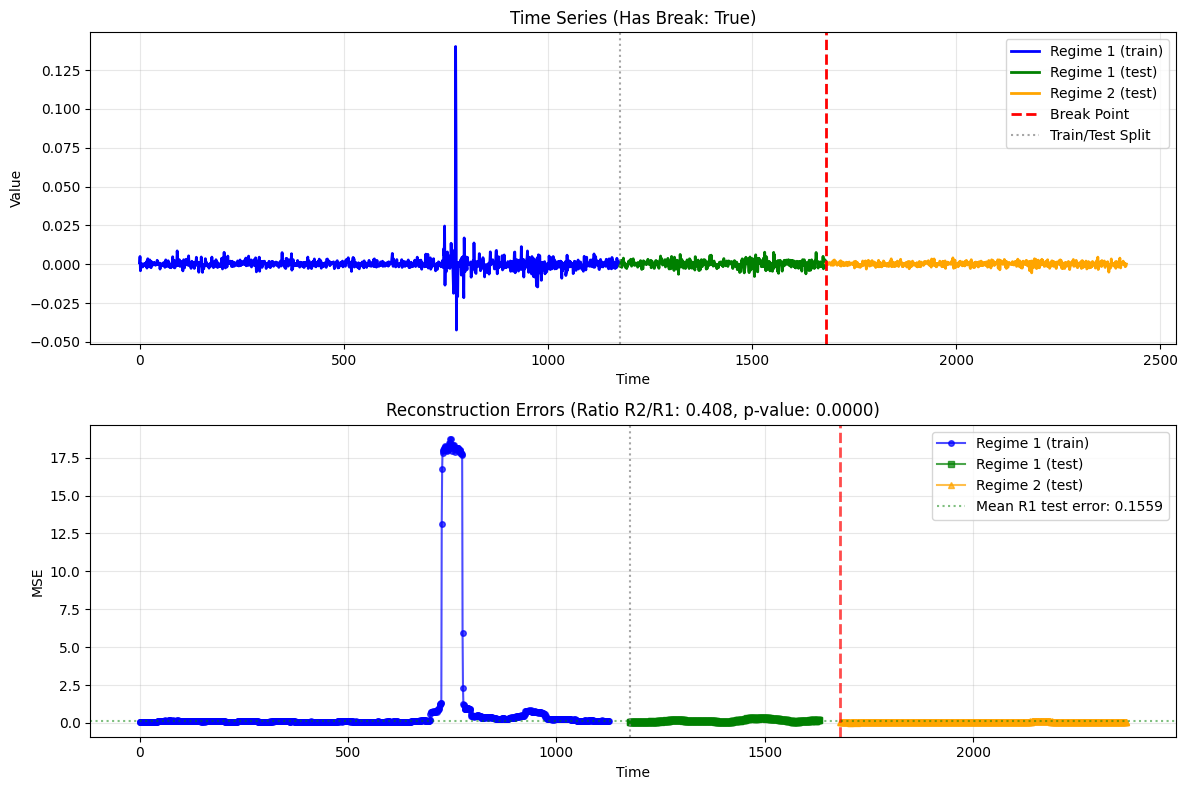

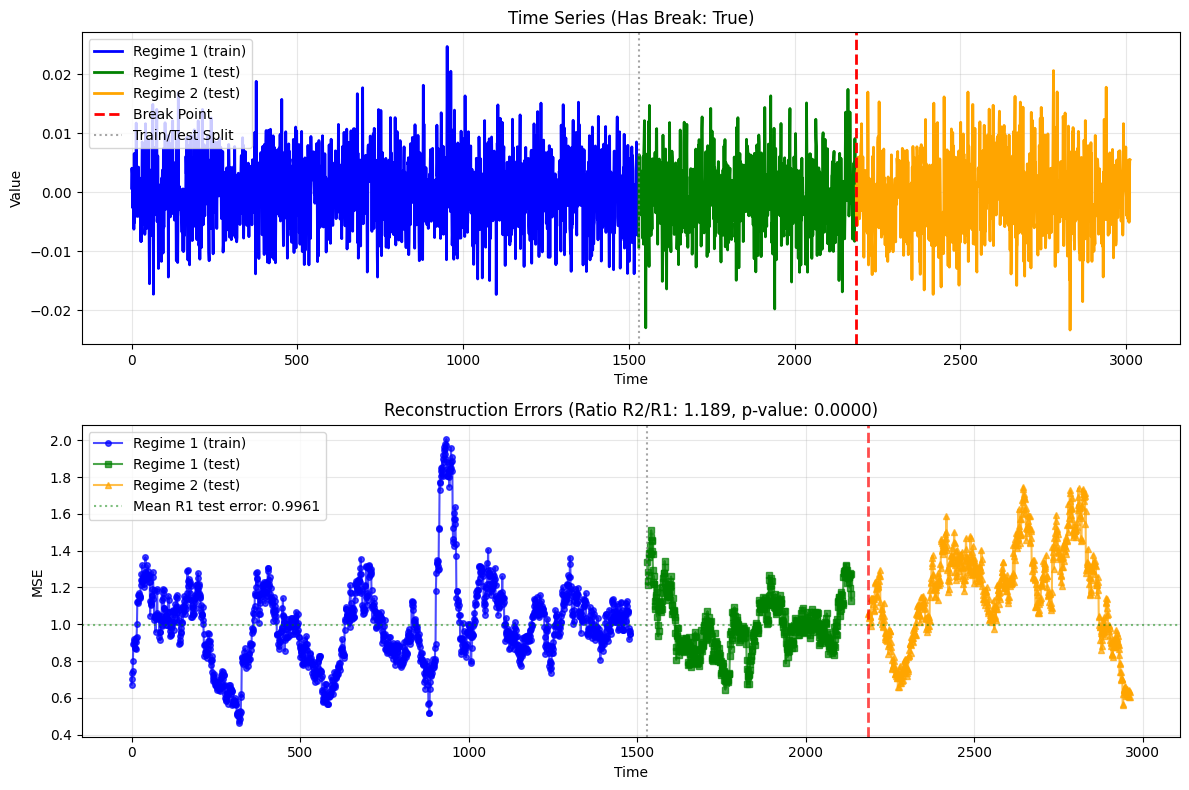

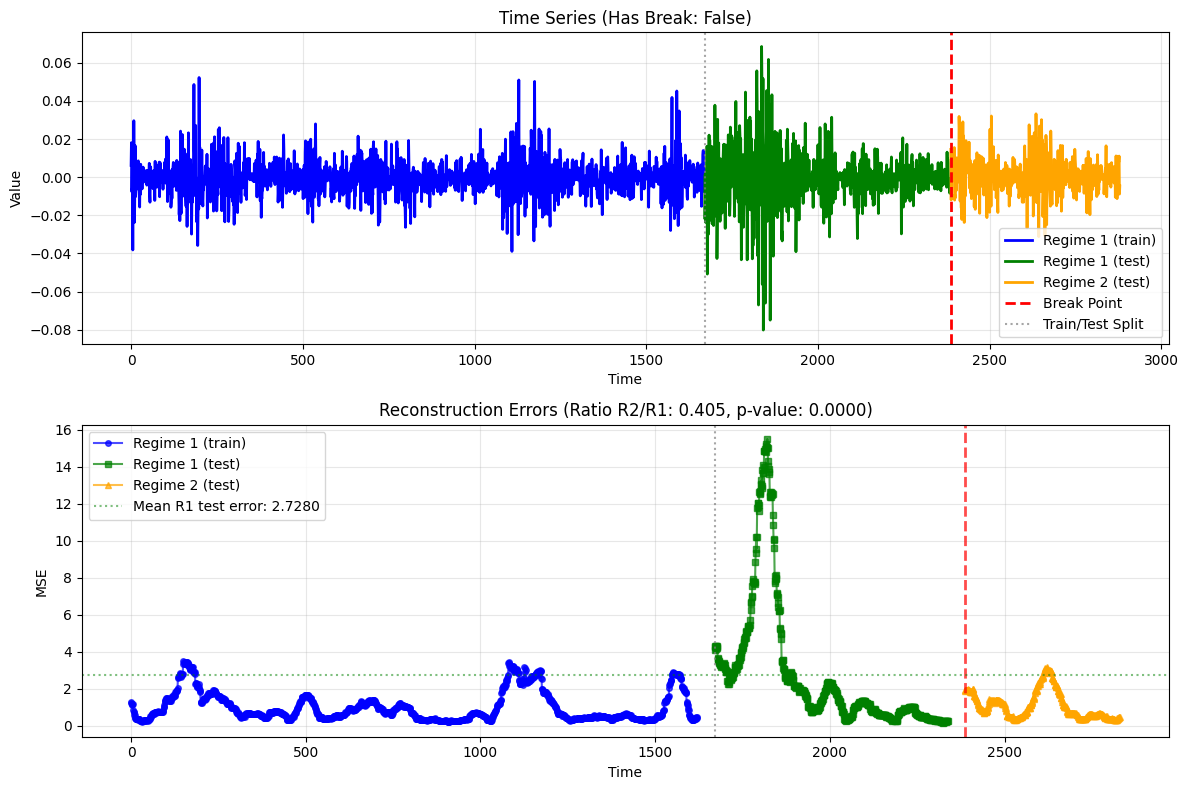

In [26]:
# Plot a few examples
print("\n=== Example Time Series ===")
for i in range(3):
    plot_example_with_errors(test_dict, i, extractor)